In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

matplotlib.rcParams.update({
    'font.family': 'serif',
    'text.usetex': True,
    'axes.labelsize': 'large',
    'figure.dpi': 100,
})

In [2]:
def f(x, A, B, C):
    return A*x + B*np.sqrt(x) + C

(31.421850165433067,
 18.720669895842633,
 -61.36223751362713,
 27.393082455885523,
 66.68734834933981,
 9.97510903779426)

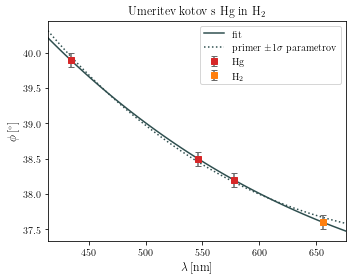

In [113]:
# Mercury (Hg) and hydrogen H_2
# Measured angles and expected wavelengths
ϕ = np.array([
    38.2, 38.5, 39.9,
    37.6
])
Δϕ = 0.1
λ_exp = 1e-9 * np.array([
    578, 546, 434,
    656
])

# Fit
par, cov = curve_fit(f, λ_exp, ϕ, sigma=Δϕ+0*ϕ, absolute_sigma=True)
A, B, C = par
σ_A, σ_B, σ_C = np.sqrt(np.diag(cov))

# Plot
fig, ax = plt.subplots(1, 1, figsize=[5, 4])

ax.errorbar(1e9 * λ_exp[:-1], ϕ[:-1], yerr=Δϕ, color='tab:red',
            fmt='s', ecolor='dimgray', capsize=3, label='Hg')
ax.errorbar(1e9 * λ_exp[-1], ϕ[-1], yerr=Δϕ, color='tab:orange',
            fmt='s', ecolor='dimgray', capsize=3, label=r'$\rm{H_2}$')

λ_lin = np.linspace(np.min(λ_exp)-20e-9, np.max(λ_exp)+20e-9)
ax.plot(1e9 * λ_lin, f(λ_lin, A, B, C), color='darkslategrey', zorder=-1, label='fit')
ax.plot(1e9 * λ_lin, f(λ_lin, A+σ_A, B-σ_B, C+σ_C), linestyle=':', color='darkslategrey', zorder=-1, label=r'primer $\pm 1\sigma$ parametrov')

ax.set_title(r'Umeritev kotov s Hg in $\rm{H_2}$')
ax.set_xlabel(r'$\lambda\,[\mathrm{nm}]$')
ax.set_ylabel(r'$\phi\,[\mathrm{^\circ}]$')
ax.set_xlim(1e9 * np.min(λ_lin), 1e9 * np.max(λ_lin))
ax.legend()
fig.tight_layout()
fig.savefig(f'phi-calibration.pdf')
1e-6 * A, 1e-6 * σ_A, 1e-3 * B, 1e-3 * σ_B, C, σ_C

Iz dobljene odvisnosti

$$\phi(\lambda) = A\lambda + B \sqrt{\lambda} + C,$$

lahko izrazimo $\lambda$

$$\lambda(\phi) = \left( \frac{-B + \sqrt{B^2 + 4A (C - \phi)}}{2A} \right)^2.$$

In [20]:
from numba import vectorize

def makefunc_calc_λ(A, B, C):
    @vectorize
    def calc_λ(ϕ):
        return ((-B - np.sqrt(B**2 - 4*A*(C-ϕ))) / (2*A))**2
    return calc_λ

calc_λ = makefunc_calc_λ(A, B, C)

In [21]:
import sympy as sym
from sympy import symbols

def Dλ_i():
    '''scope'''
    syms = symbols('ϕ A B C')
    ϕ, A, B, C = syms
    λ = ((-B - sym.sqrt(B**2 - 4*A*(C-ϕ))) / (2*A))**2
    # Vector of partial derivatives of λ by x_i
    Dλ_i = sym.lambdify(syms, [λ.diff(x_i) for x_i in syms])
    return Dλ_i
Dλ_i = Dλ_i()

In [22]:
import imageio.v2 as imageio

# Load image and use it to make a colormap
spectrum = imageio.imread('./sRGB-approx.png', pilmode='RGB')[0]
def colormap(λ):
    i = np.interp(λ, [380e-9, 710e-9], [0, len(spectrum)]).astype(int)
    return spectrum[i] / 255

vijolična & 38.0 & 601 \\
moder prehod & 38.4 & 556 \\
zelena B & 38.4 & 556 \\
zelena A & 38.5 & 546 \\
rdeča & 39.1 & 492 \\


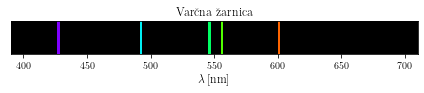

In [138]:
# Incandescent lamp
# Measured angles
ϕ = np.array([
    38.0, 38.4, 38.4, 38.5, 39.1, 40.0
])
λ = calc_λ(ϕ)
# Error
Δx_i = np.array([0.1, σ_A, σ_B, σ_C])
Dλ_i_at_ϕ = [Dλ_i(ϕ_j, A, B, C) for ϕ_j in ϕ]
Δλ = np.sqrt(
    np.sum((np.array(Dλ_i_at_ϕ) * Δx_i)**2, axis=1))

# Plot
fig, ax = plt.subplots(1, 1, figsize=[6, 1.4])

ax.bar(1e9 * λ, 1, width=2, color=colormap(λ))
# ax.errorbar(1e9 * λ, 0.5 * (1**np.arange(len(λ))), xerr=1e9 * Δλ, color='w',
#             fmt='.', markersize=0, ecolor='w', capsize=2, label='Hg')

ax.set_title(f'Varčna žarnica')
ax.set_xlabel(r'$\lambda\,[\mathrm{nm}]$')
ax.set_facecolor('black')
ax.set_xlim(390, 710)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_yticklabels([])
fig.tight_layout()
fig.savefig(f'incandescent-spectrum.pdf')

# Printout
aux = [
    ['vijolična', 'moder prehod', 'zelena B', 'zelena A', 'rdeča'],
    ϕ, λ
]
for name, ϕ, λ in zip(*aux):
    print(f'{name} & {ϕ:.1f} & {1e9 * λ:.0f} \\\\')

rdeča & 37.5 & 37.9 & 614 & 672 \\
zelena & 37.8 & 38.3 & 567 & 627 \\
rumena & 37.7 & 38.3 & 567 & 641 \\
modra & 38.6 & 39.6 & 455 & 536 \\


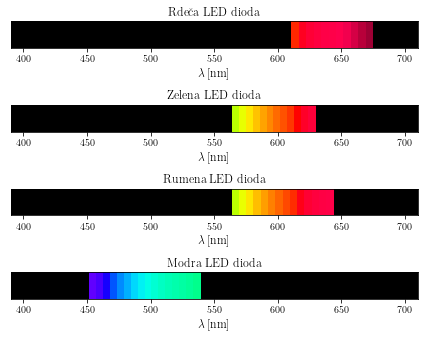

In [129]:
# Red, green, yellow, blue
# Measured angles
ϕ_min = np.array([
    37.5, 37.8, 37.7, 38.6
])
ϕ_max = np.array([
    37.9, 38.3, 38.3, 39.6
])
λ_min = calc_λ(ϕ_max)
λ_max = calc_λ(ϕ_min)

# Plot
fig, axs = plt.subplots(4, 1, figsize=[6, 4*1.2])

aux = [
    ['rdeča', 'zelena', 'rumena', 'modra'],
    axs.flat,
    np.stack([λ_min, λ_max], axis=1),
    np.stack([ϕ_min, ϕ_max], axis=1)
]
for name, ax, (λ_min, λ_max), (ϕ_min, ϕ_max) in zip(*aux):
    # Plot
    δλ = 5e-9
    λ_lin = np.linspace(λ_min, λ_max, int((λ_max - λ_min)/δλ))
    for λ in λ_lin:
        ax.bar(1e9 * λ, 1, width=1e9 * 1.2*δλ, color=colormap(λ))
    print(f'{name} & {ϕ_min:.1f} & {ϕ_max:.1f} & {1e9 * λ_min:.0f} & {1e9 * λ_max:.0f} \\\\')
    
    ax.set_title(f'{str.capitalize(name)} LED dioda')
    ax.set_xlabel(r'$\lambda\,[\mathrm{nm}]$')
    ax.set_facecolor('black')
    ax.set_xlim(390, 710)
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    ax.set_yticklabels([])
fig.tight_layout()
fig.savefig(f'LED-spectra.pdf')

vijolična & 38.0 & 601 \\
svetlomodra & 38.8 & 518 \\
oranžna & 39.6 & 455 \\


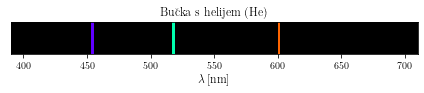

In [132]:
# Helium (He) lamp
# Measured angles
ϕ = np.array([
    38.0, 38.8, 39.6
])
λ = calc_λ(ϕ)
# Error
Δx_i = np.array([0.1, σ_A, σ_B, σ_C])
Dλ_i_at_ϕ = [Dλ_i(ϕ_j, A, B, C) for ϕ_j in ϕ]
Δλ = np.sqrt(
    np.sum((np.array(Dλ_i_at_ϕ) * Δx_i)**2, axis=1))

# Plot
fig, ax = plt.subplots(1, 1, figsize=[6, 1.4])

ax.bar(1e9 * λ, 1, width=2, color=colormap(λ))

ax.set_title(f'Bučka s helijem (He)')
ax.set_xlabel(r'$\lambda\,[\mathrm{nm}]$')
ax.set_facecolor('black')
ax.set_xlim(390, 710)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_yticklabels([])
fig.tight_layout()
fig.savefig(f'He-spectrum.pdf')

# Printout
aux = [
    ['vijolična', 'svetlomodra', 'oranžna'],
    ϕ, λ
]
for name, ϕ, λ in zip(*aux):
    print(f'{name} & {ϕ:.1f} & {1e9 * λ:.0f} \\\\')

rumena & 37.7 & 641 \\
oranžna & 37.9 & 614 \\
rdeča & 38.1 & 589 \\


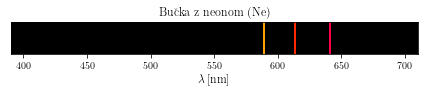

In [133]:
# Neon (Ne) lamp
# Measured angles
ϕ = np.array([
    37.7, 37.9, 38.1
])
λ = calc_λ(ϕ)
# Error
Δx_i = np.array([0.1, σ_A, σ_B, σ_C])
Dλ_i_at_ϕ = [Dλ_i(ϕ_j, A, B, C) for ϕ_j in ϕ]
Δλ = np.sqrt(
    np.sum((np.array(Dλ_i_at_ϕ) * Δx_i)**2, axis=1))

# Plot
fig, ax = plt.subplots(1, 1, figsize=[6, 1.4])

ax.bar(1e9 * λ, 1, width=2, color=colormap(λ))

ax.set_title(f'Bučka z neonom (Ne)')
ax.set_xlabel(r'$\lambda\,[\mathrm{nm}]$')
ax.set_facecolor('black')
ax.set_xlim(390, 710)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_yticklabels([])
fig.tight_layout()
fig.savefig(f'Ne-spectrum.pdf')

# Printout
aux = [
    ['rumena', 'oranžna', 'rdeča'],
    ϕ, λ
]
for name, ϕ, λ in zip(*aux):
    print(f'{name} & {ϕ:.1f} & {1e9 * λ:.0f} \\\\')

589.1811746252724

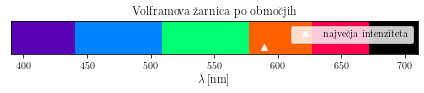

In [117]:
# Red, green, yellow, blue
# Measured angles
ϕ_min = np.array([
    37.5, 37.8, 38.2, 38.9, 39.8
])
ϕ_max = np.array([
    37.8, 38.2, 38.9, 39.8, 40.6
])
λ_min = calc_λ(ϕ_max)
λ_max = calc_λ(ϕ_min)

# Plot
fig, ax = plt.subplots(1, 1, figsize=[6, 1.4])

# Max intensity λ
ax.plot(1e9 * calc_λ(38.1), 0.2, linestyle='', zorder=10,
        marker='^', color='1', label='največja intenziteta')


aux = [
    np.stack([λ_min, λ_max], axis=1)
]
for (λ_min, λ_max), in zip(*aux):
    # Plot
    λ = (λ_min + λ_max)/2
    Δλ = λ_max - λ_min
    ax.bar(1e9 * λ, 1, width=1e9 * Δλ, color=colormap(λ))

    
ax.set_title(f'Volframova žarnica po območjih')
ax.set_xlabel(r'$\lambda\,[\mathrm{nm}]$')
ax.set_facecolor('black')
ax.set_xlim(390, 710)
ax.set_ylim(0, 1)
ax.set_yticks([])
ax.set_yticklabels([])
ax.legend()
fig.tight_layout()
fig.savefig(f'thermal-spectrum.pdf')

1e9 * calc_λ(38.1)